In [1]:
import importlib
import os
import pandas as pd
from pathlib import Path
import immloom.io_utils, immloom.segments, immloom.viz


f_path = Path('../data/processed/dataset_01/patchwork_output/IGH/pairwise_alignments/')
self_lst = sorted([x for x in os.listdir(f_path) if x[:4]=='self'])

f_name = self_lst[0]
print(f_name)
pi_min = 80.0
init_segm_length_min = 10000
segm_length_min = 2000
dist_max = 2000
block_length_min = 2000


self_0-s01_h1_IGH.tsv


Initial: 13659
Filtered: 48
Symmetric: 47
Up-right: 24


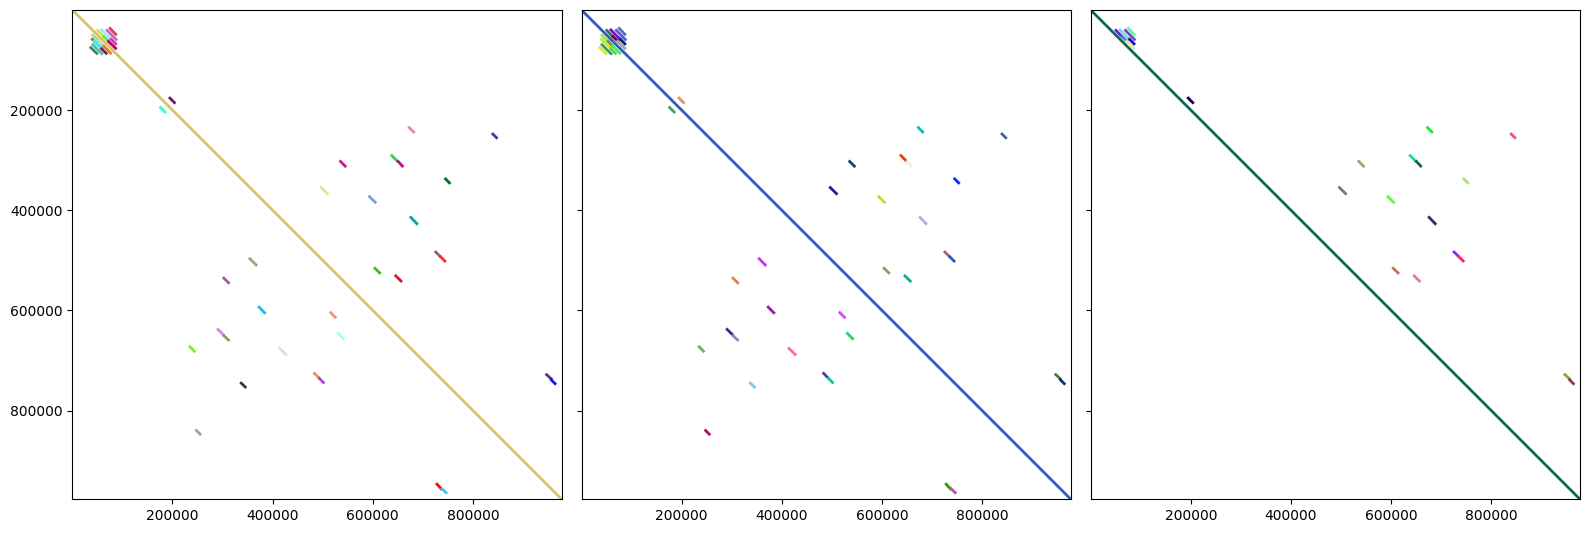

In [2]:
importlib.reload(immloom.io_utils)
importlib.reload(immloom.segments)
importlib.reload(immloom.viz)
from immloom.io_utils import segm_preprocess, segm_filter
from immloom.segments import segm_symmetric, merge_segments
from immloom.viz import plot_segments, plot_segments_c


df = segm_preprocess(f_path, f_name)
# df = df[df.x2<=100000]
# df = df[df.y2<=100000]
# df = df.reset_index(drop=True)
# df.loc[df.shape[0]] = [1, 100000, 1, 100000, '+', 100000, 100.0]
print('Initial:', df.shape[0])
df1 = segm_filter(df, pi=pi_min, length=init_segm_length_min)
print('Filtered:', df1.shape[0])
df2 = segm_symmetric(df1)
print('Symmetric:', df2.shape[0])
df3= df2[df2.x1 >= df2.y1]
print('Up-right:', df3.shape[0])
plot_segments_c(df1, df2, df3)


Merged: 20
Splited: 20


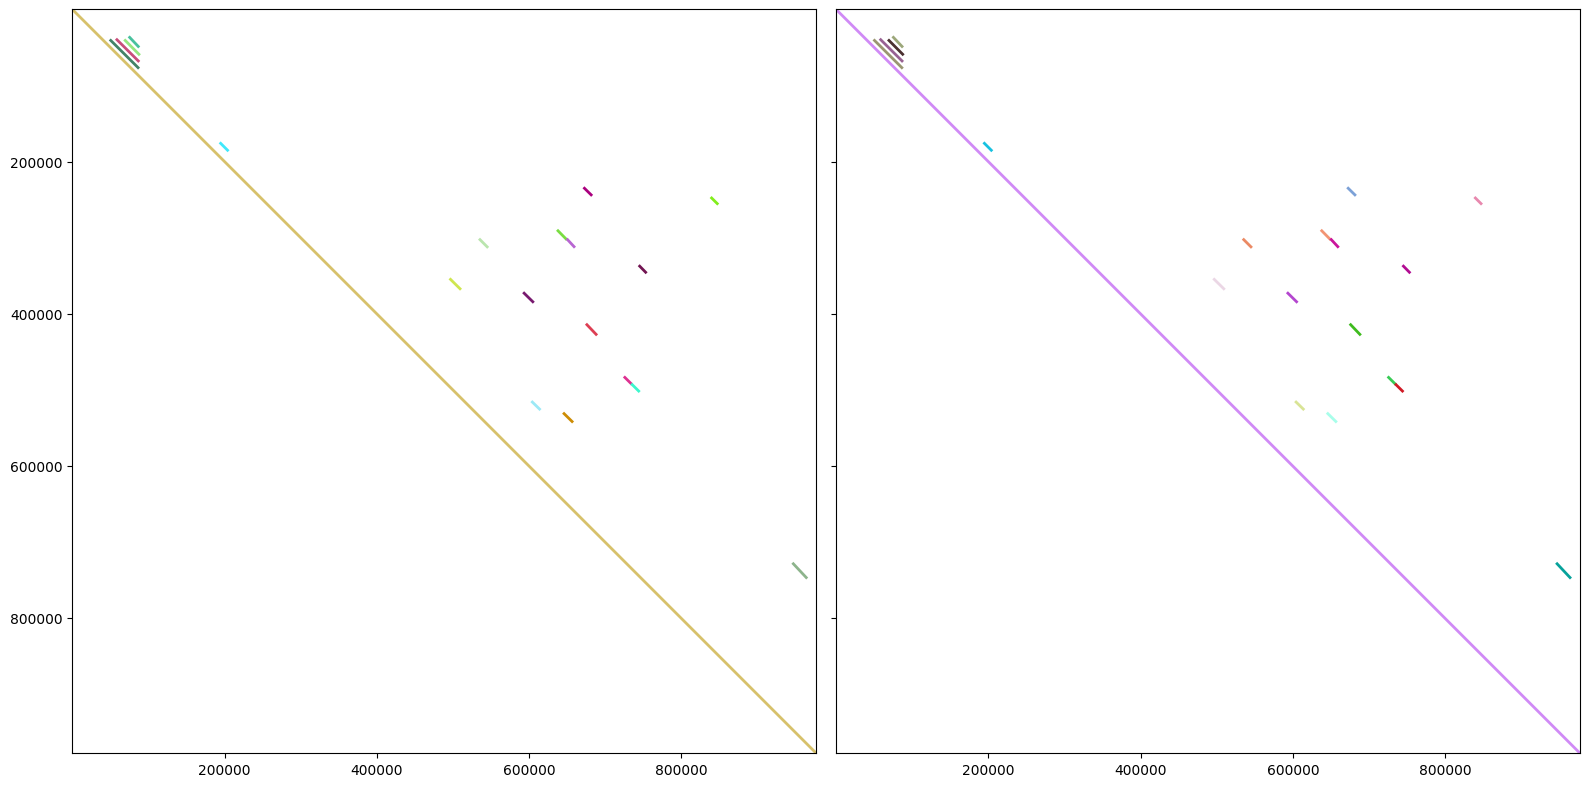

In [3]:
importlib.reload(immloom.segments)
from immloom.segments import merge_segments, split_segments


df4 = merge_segments(df3, dist_max=dist_max)
print('Merged:', df4.shape[0])
dfn = df4[df4.strand=='-']
split_points = sorted(list(set(list(dfn.x1)+list(dfn.x2)+list(dfn.y1)+list(dfn.y2))))
df5 = split_segments(df4, split_points = split_points, length_min=segm_length_min)
print('Splited:', df5.shape[0])
#plot_segments(df4)
plot_segments_c(df4, df5)


In [4]:
importlib.reload(immloom.segments)
from immloom.segments import find_containing_projids, find_proj, find_reversed_intervals, reflect_segments


if df5[df5.strand=='-'].shape[0]>0:
    df6, df7 = find_proj(df5)
    split_points = list(df7.d1)+list(df7.d2)
    df8 = split_segments(df5, split_points = split_points, length_min=segm_length_min)
    res = df8.apply(find_containing_projids, axis=1, df7=df7)
    df8_with_hits = pd.concat([df8.reset_index(drop=True), res], axis=1)
    df8_in = df8_with_hits[df8_with_hits['which'] != 'none'].copy()
    df8_lst = list(df8_in[df8_in.which!='both'].proj_x) + list(df8_in[df8_in.which!='both'].proj_y)
    df8_lst = [x for sub in df8_lst for x in sub]
    G, inv_indices = find_reversed_intervals(df6, df7, target_nodes=df8_lst)
    split_points = list(df7.d1)+list(df7.d2)
    df8 = split_segments(df5, split_points = split_points, length_min=segm_length_min)
    df9 = reflect_segments(df8, df7, inv_indices, G, plot=True)
    assert not (df9['x1'] > df9['x2']).any() and not (df9['y1'] > df9['y2']).any(), \
        "Found rows with x1>x2 or y1>y2"
else:
    df9 = df5


In [5]:
# df_inv = df7.loc[inv_indices, :][['d1', 'd2']].reset_index(drop=True)

In [6]:
segm_length_min

2000

In [7]:
#plot_segments_c(df9)

76
41


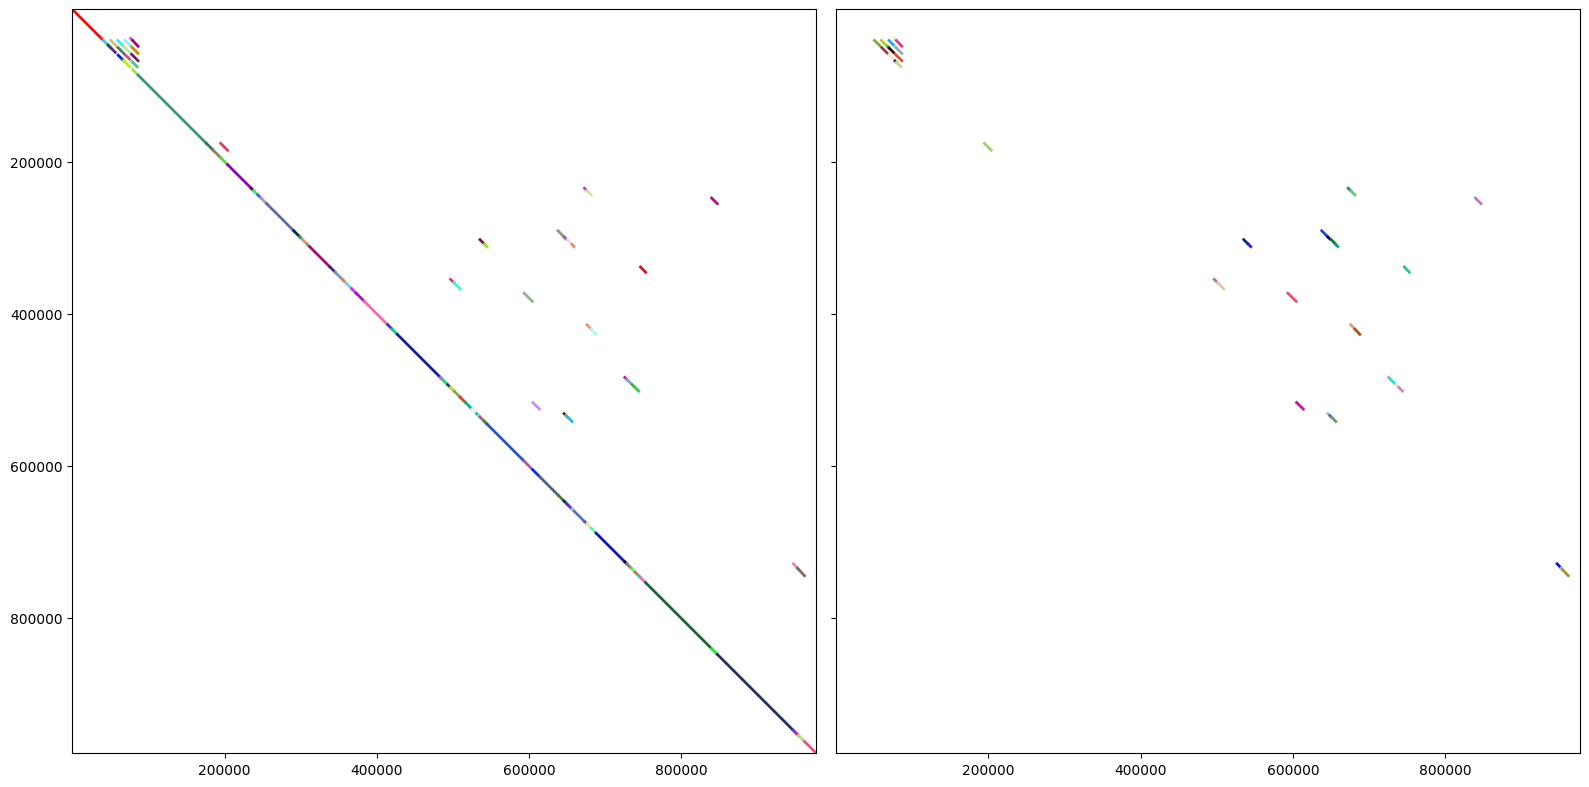

In [8]:
df9_nd = df9[(df9.x1!=df9.y1) | (df9.x2!=df9.y2)]
df9_d = df9[(df9.x1==df9.y1) & (df9.x2==df9.y2)]
#plot_segments_c(df9, df9_nd, df9_d)

df10_nd = split_segments(df9_nd, length_min=segm_length_min)
split_points = sorted(list(set(list(df10_nd.x1) + list(df10_nd.x2) + list(df10_nd.y1) + list(df10_nd.y2))))
df10_d = split_segments(df9_d, split_points=split_points, length_min=2000)
#plot_segments_c(df10_nd, df10_d)

df10 = pd.concat([df10_nd, df10_d])
#plot_segments_c(df10)
#10 = split_segments(df9, length_min=5000)
# print(df9.shape[0])
# print(df10.shape[0])
dsegm1 = df10[(df10.x1==df10.y1) & (df10.x2==df10.y2)].reset_index(drop=True)
dsegm1 = dsegm1[dsegm1.length>=block_length_min]
dsegm1['dsegm_id'] = dsegm1.index
dsegm1['d1'] = dsegm1['x1']
dsegm1['d2'] = dsegm1['x2']
dsegm1 = dsegm1.drop(columns=['x1', 'x2', 'y1', 'y2'])
print(dsegm1.shape[0])
df11 = df10[(df10.x1!=df10.y1) | (df10.x2!=df10.y2)].reset_index(drop=True)
print(df11.shape[0])

plot_segments_c(df10, df11)

In [9]:
importlib.reload(immloom.segments)
from immloom.segments import find_overlap


df11.loc[:,'proj_id_x'] = df11.apply(lambda r: find_overlap(r, dsegm1, axis='x'), axis=1)
df11.loc[:,'proj_id_y'] = df11.apply(lambda r: find_overlap(r, dsegm1, axis='y'), axis=1)

In [10]:
import networkx as nx
from collections import defaultdict


edges = (df11[['proj_id_x', 'proj_id_y']].values.tolist())
edges = [tuple(edge) for edge in edges if ((edge[0] != edge[1]) & (edge[0] != -1) & (edge[1] != -1))]
G = nx.Graph()
G.add_edges_from(edges)
comp_dict = defaultdict(int)
for comp_id, comp in enumerate(nx.connected_components(G), start=1):
    for node in comp:
        comp_dict[int(node)] = comp_id
print('Number of blocks:', comp_id)


Number of blocks: 21


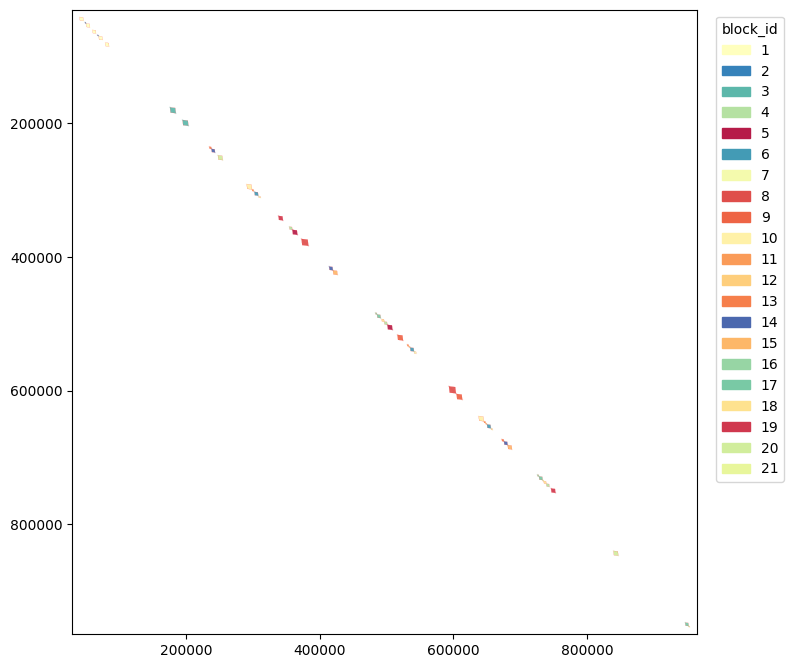

In [11]:
import matplotlib.pyplot as plt
importlib.reload(immloom.viz)
from immloom.viz import plot_necklace_diagonal


dsegm1['block_id'] = dsegm1['dsegm_id'].astype(int).apply(lambda x: comp_dict[x])

fig, ax = plt.subplots(figsize=(8, 8))
colors = plot_necklace_diagonal(ax, dsegm1[dsegm1.block_id!=0], title='', 
                                info_text='')
plt.tight_layout()
plt.show()
